In [8]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from datetime import datetime

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Single scan, WITHOUT TT correction

In [9]:
fc = FileChooser('/sf/alvra/data/p19506/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19506/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [19]:
Timezero_mm = 28.08187 # position of Timezero on PP delay (in mm!)
Timezero_fs = Timezero_mm *2/(299792458*1e3*1e-15)
quantile_corr = 0.3

channel_list_pp = [channel_Events, channel_APD_Ch1, channel_APD_Ch2, channel_Izero117, 'SLAAR11-LSCP1-FNS:CH5:VAL_GET']
channel_list_all = channel_list_pp + [channel_delay_topas]

########################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_fs = np.asarray(scan.readbacks) - Timezero_fs

Izero_pump = []
Izero_unpump = []
ch5_pump = []
ch5_unpump = []

DataAPD1_pump = []
DataAPD1_unpump = []
Pump_probe_APD1 = []

DataAPD2_pump = []
DataAPD2_unpump = []
Pump_probe_APD2 = []

for i, step in enumerate(scan):
#    try:
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]

    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

    ch5_pump_shot = resultsPP['SLAAR11-LSCP1-FNS:CH5:VAL_GET'].pump
    ch5_unpump_shot = resultsPP['SLAAR11-LSCP1-FNS:CH5:VAL_GET'].unpump

    df_ch5_pump = pd.DataFrame(ch5_pump_shot)
    df_ch5_unpump = pd.DataFrame(ch5_unpump_shot)
    ch5_pump.append(np.nanquantile(df_ch5_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    ch5_unpump.append(np.nanquantile(df_ch5_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))

    IzeroFEL_pump_shot = resultsPP[channel_Izero117].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero117].unpump
    DataAPD1_pump_shot = resultsPP[channel_APD_Ch1].pump
    DataAPD1_unpump_shot = resultsPP[channel_APD_Ch1].unpump
    DataAPD2_pump_shot = resultsPP[channel_APD_Ch2].pump
    DataAPD2_unpump_shot = resultsPP[channel_APD_Ch2].unpump

    DataAPD1_pump_shot_norm = DataAPD1_pump_shot / IzeroFEL_pump_shot
    DataAPD1_unpump_shot_norm = DataAPD1_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_APD1_shot = DataAPD1_pump_shot_norm - DataAPD1_unpump_shot_norm

    DataAPD2_pump_shot_norm = DataAPD2_pump_shot / IzeroFEL_pump_shot
    DataAPD2_unpump_shot_norm = DataAPD2_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_APD2_shot = DataAPD2_pump_shot_norm - DataAPD2_unpump_shot_norm

    df_Izero_pump = pd.DataFrame(IzeroFEL_pump_shot)
    df_Izero_unpump = pd.DataFrame(IzeroFEL_unpump_shot)

    Izero_pump.append(np.nanquantile(df_Izero_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    Izero_unpump.append(np.nanquantile(df_Izero_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))

    df_pump_APD1 = pd.DataFrame(DataAPD1_pump_shot_norm)
    df_unpump_APD1 = pd.DataFrame(DataAPD1_unpump_shot_norm)
    df_pump_probe_APD1 = pd.DataFrame(Pump_probe_APD1_shot)

    df_pump_APD2 = pd.DataFrame(DataAPD2_pump_shot_norm)
    df_unpump_APD2 = pd.DataFrame(DataAPD2_unpump_shot_norm)
    df_pump_probe_APD2 = pd.DataFrame(Pump_probe_APD2_shot)

    DataAPD1_pump.append(np.nanquantile(df_pump_APD1, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    DataAPD1_unpump.append(np.nanquantile(df_unpump_APD1, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    Pump_probe_APD1.append(np.nanquantile(df_pump_probe_APD1, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))

    DataAPD2_pump.append(np.nanquantile(df_pump_APD2, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    DataAPD2_unpump.append(np.nanquantile(df_unpump_APD2, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    Pump_probe_APD2.append(np.nanquantile(df_pump_probe_APD2, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))

#    except:
#        Delay_fs = np.delete(Delay_fs, i)


print ('Step {} of {}: Processed {}'.format(i+1, len(scan.files), filename))
print ("correlation APD1 = {}".format(pearsonr(IzeroFEL_pump_shot,DataAPD1_pump_shot)[0]))
print ("correlation APD2 = {}".format(pearsonr(IzeroFEL_pump_shot,DataAPD2_pump_shot)[0]))
    
Delay_fs = Delay_fs[:np.shape(Pump_probe_APD1)[0]]

DataAPD1_pump = np.asarray(DataAPD1_pump)
DataAPD1_unpump = np.asarray(DataAPD1_unpump)
Pump_probe_APD1 = np.asarray(Pump_probe_APD1)

DataAPD2_pump = np.asarray(DataAPD2_pump)
DataAPD2_unpump = np.asarray(DataAPD2_unpump)
Pump_probe_APD2 = np.asarray(Pump_probe_APD2)
                            
Izero_pump = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)

ch5_pump = np.asarray(ch5_pump)
ch5_unpump = np.asarray(ch5_unpump)

# minlen = min(len(i) for i in Pump_probe_APD1)
# def cut(arr, minlen):
#     return np.array([i[:minlen] for i in arr])

# DataAPD1_pump = cut(DataAPD1_pump, minlen)
# DataAPD1_unpump = cut(DataAPD1_unpump, minlen)
# Pump_probe_APD1 = cut(Pump_probe_APD1, minlen)
# DataAPD2_pump = cut(DataAPD2_pump, minlen)
# DataAPD2_unpump2 = cut(DataAPD2_unpump, minlen)
# Pump_probe_APD2 = cut(Pump_probe_APD2, minlen)

# Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !
Delay_ps = Delay_fs/1000.

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_corr/2, 0.5 + quantile_corr/2))


/das/work/p17/p17589/dev/alvra_tools/alvra_tools/load_data.py:591: RuntimeWarning: divide by zero encountered in long_scalars
  if ((100 / laser_reprate) == FEL_reprate):
/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet       1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET      1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET      1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY      996 / 1002 -> 1% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS    1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH5:VAL_GET 1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 996 / 1002 -> 1% loss
complete channels: 5 / 6 -> 17% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 0:1
Loaded 996 pump and 0 unpump shots


ValueError: operands could not be broadcast together with shapes (996,) (0,) 

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


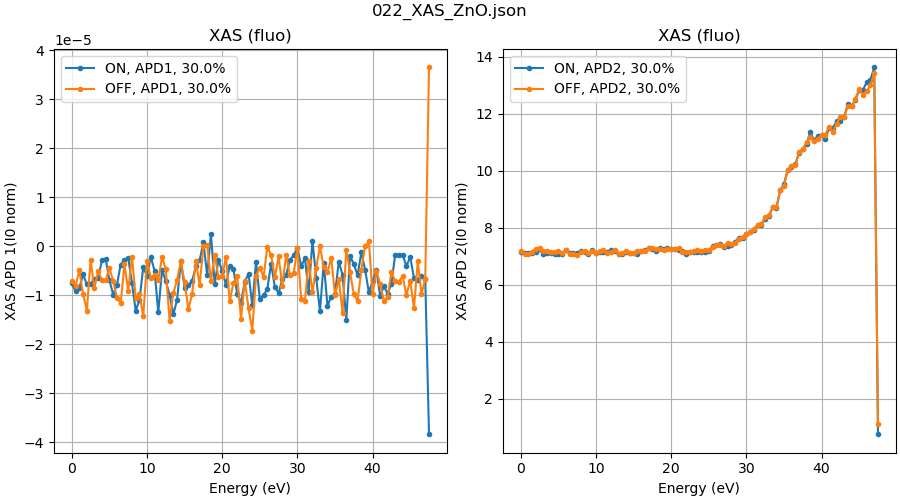

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

#Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS_APD1_pump = DataAPD1_pump[:,0]
err_APD1_low_pump = DataAPD1_pump[:,1]
err_APD1_high_pump = DataAPD1_pump[:,2]
XAS_APD1_unpump = DataAPD1_unpump[:,0]
err_APD1_low_unpump = DataAPD1_unpump[:,1]
err_APD1_high_unpump = DataAPD1_unpump[:,2]
XAS_APD1_pump_probe = Pump_probe_APD1[:,0]
err_APD1_low_pump_probe = Pump_probe_APD1[:,1]
err_APD1_high_pump_probe = Pump_probe_APD1[:,2]

XAS_APD2_pump = DataAPD2_pump[:,0]
err_APD2_low_pump = DataAPD2_pump[:,1]
err_APD2_high_pump = DataAPD2_pump[:,2]
XAS_APD2_unpump = DataAPD2_unpump[:,0]
err_APD2_low_unpump = DataAPD2_unpump[:,1]
err_APD2_high_unpump = DataAPD2_unpump[:,2]
XAS_APD2_pump_probe = Pump_probe_APD2[:,0]
err_APD2_low_pump_probe = Pump_probe_APD2[:,1]
err_APD2_high_pump_probe = Pump_probe_APD2[:,2]

# plt.subplot(1,2,1)
ax1.plot(np.arange(0,len(Delay_ps))*0.5,XAS_APD1_pump, label='ON, APD1, {}%'.format(quantile_corr*100),marker='.')
#ax1.plot(Delay_ps,XAS_APD1_pump, label='ON, APD1, {}%'.format(quantile_corr*100),marker='.')
#ax1.fill_between(Delay_ps, err_APD1_low_pump, err_APD1_high_pump, color='lightblue')

ax1.plot(np.arange(0,len(Delay_ps))*0.5, XAS_APD1_unpump, label='OFF, APD1, {}%'.format(quantile_corr*100),marker='.')
#ax1.plot(Delay_ps, XAS_APD1_unpump, label='OFF, APD1, {}%'.format(quantile_corr*100),marker='.')
#ax1.fill_between(Delay_ps, err_APD1_low_unpump, err_APD1_high_unpump, color='navajowhite')

# ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax1.set_xlabel("Delay_ps")
ax1.set_ylabel ("XAS APD 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

# plt.subplot(1,2,2)
ax2.plot(np.arange(0,len(Delay_ps))*0.5, XAS_APD2_pump, label='ON, APD2, {}%'.format(quantile_corr*100),marker='.')
#ax2.plot(Delay_ps, XAS_APD2_pump, label='ON, APD2, {}%'.format(quantile_corr*100),marker='.')
#ax2.fill_between(Delay_ps, err_APD2_low_pump, err_APD2_high_pump, color='lightblue')

ax2.plot(np.arange(0,len(Delay_ps))*0.5, XAS_APD2_unpump, label='OFF, APD2, {}%'.format(quantile_corr*100),marker='.')
#ax2.plot(Delay_ps, XAS_APD2_unpump, label='OFF, APD2, {}%'.format(quantile_corr*100),marker='.')
#ax2.fill_between(Delay_ps, err_APD2_low_unpump, err_APD2_high_unpump, color='navajowhite')

# ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax2.set_xlabel("Delay_ps")
ax2.set_ylabel ("XAS APD 2(I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
#ax2.set_xlim(-1,5)
ax2.grid()

#plt.subplot(1,3,3)
#plt.plot(Delay_ps, XAS_APD_pump_probe, label='pump-probe, APD, {}%'.format(quantile_corr*100),color='green', marker='.')
#plt.fill_between(Delay_ps,err_APD_low_pump_probe, err_APD_high_pump_probe, color='lightgreen')

#plt.plot(Delay_ps, XAS_PIPS_pump_probe, label='pump-probe, PIPS, {}%'.format(quantile_corr*100),color='magenta', marker='.')
#plt.fill_between(Delay_ps,err_PIPS_low_pump_probe, err_PIPS_high_pump_probe, color='pink')


#plt.xlabel("Energy (eV)")
#plt.ylabel ("DeltaXAS (I0 norm)")
#plt.gca().set_title('pump-probe vs energy')
#plt.legend(loc="best")
#plt.grid()
# plt.tight_layout()

plt.show()



/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


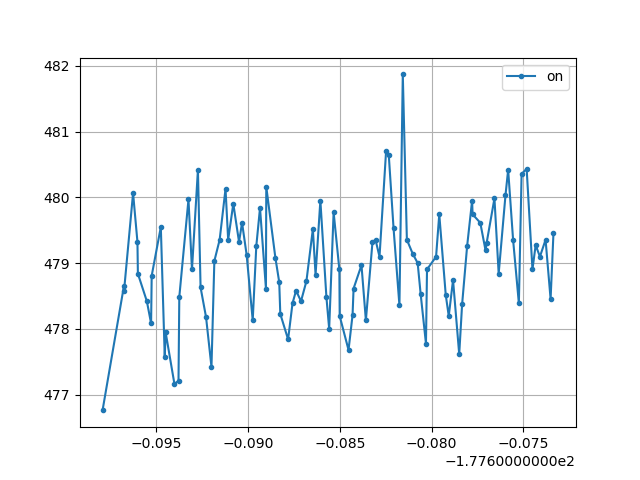

In [16]:
plt.figure()
plt.plot(Delay_ps, ch5_pump[:,0], marker = '.', label = 'on')
#plt.plot(Delay_ps, ch5_unpump[:,0], marker ='.', label = 'off')
plt.legend(loc = 'best')
#plt.xlim(-1,5)
plt.grid()
plt.show()

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


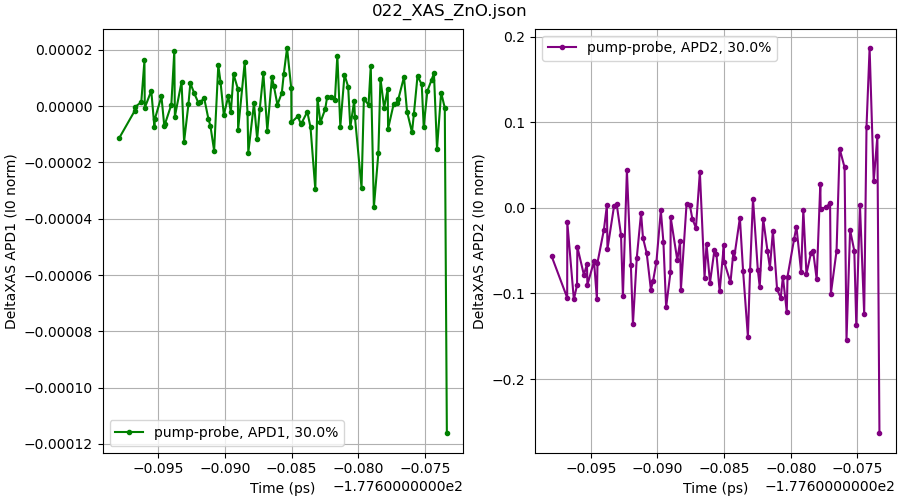

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

# plt.subplot(1,2,1)
ax1.plot(Delay_ps, XAS_APD1_pump_probe, label='pump-probe, APD1, {}%'.format(quantile_corr*100),color='green', marker='.')
#ax1.fill_between(Delay_ps,err_APD1_low_pump_probe, err_APD1_high_pump_probe, color='lightgreen')

ax1.set_xlabel("Time (ps)")
ax1.set_ylabel ("DeltaXAS APD1 (I0 norm)")
ax1.set_title('')
ax1.legend(loc="best")
#ax1.set_ylim(-0.05,0.1)
#ax1.set_xlim(-1,5)
ax1.grid()
# plt.tight_layout()

# plt.subplot(1,2,2)
ax2.plot(Delay_ps, XAS_APD2_pump_probe, label='pump-probe, APD2, {}%'.format(quantile_corr*100),color='purple', marker='.')
#ax2.fill_between(Delay_ps,err_APD2_low_pump_probe, err_APD2_high_pump_probe, color='lavender')

ax2.set_xlabel("Time (ps)")
ax2.set_ylabel ("DeltaXAS APD2 (I0 norm)")
ax2.set_title('')
ax2.legend(loc="best")
#ax2.set_ylim(-0.05,0.02)
#ax2.set_xlim(-1,5)
ax2.grid()
# plt.tight_layout()


plt.show()


In [79]:
33.0339 - 32.8592

0.1747000000000014

# Loop of scans, WITHOUT TT correction

In [14]:
datafiles = []
for file in glob('/sf/alvra/data/p18956/raw/scan_info/NiABT_800nm_SKedge_timescan_2469p6eV_075*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:-1]
patch

['/sf/alvra/data/p18956/raw/scan_info/NiABT_800nm_SKedge_timescan_2469p6eV_075_001.json',
 '/sf/alvra/data/p18956/raw/scan_info/NiABT_800nm_SKedge_timescan_2469p6eV_075_002.json',
 '/sf/alvra/data/p18956/raw/scan_info/NiABT_800nm_SKedge_timescan_2469p6eV_075_003.json',
 '/sf/alvra/data/p18956/raw/scan_info/NiABT_800nm_SKedge_timescan_2469p6eV_075_004.json']

In [15]:
Timezero = 197.2962 # position of Timezero on PP delay (in mm!)

quantile_band = 0.2

channel_list_pp = [channel_Events, channel_APD_Ch1, channel_Izero117]
channel_list_all = channel_list_pp + [channel_delay_harm]

#####################################################################################

from sfdata import SFScanInfo
import itertools

Pump_probe_all = []
t0_fs_loop =[]
timestamp = []
scan_number = []

for json_file in patch:
    
    DataFluo_pump = []
    DataFluo_unpump = []
    err_DataFluo_pump = []
    err_DataFluo_unpump = []
    Pump_probe = []
    err_Pump_probe = []

    print (json_file)
    
    scan_number.append(json_file.split('/')[-1].split('_')[-1].split('.')[0])
    scan = SFScanInfo(json_file)
    Delay_mm = scan.readbacks
    
    for i, step in enumerate(scan):    
        
    #    try:
        
        resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

        IzeroFEL_pump_shot = resultsPP[channel_Izero117].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero117].unpump
        DataFluo_pump_shot = resultsPP[channel_APD_Ch1].pump
        DataFluo_unpump_shot = resultsPP[channel_APD_Ch1].unpump

        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm

        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)

        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    #    except:
    #         print ('skipped Run')
        clear_output(wait=True)
        print ("correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), scan.files[i][1]))
        #Pump_probe_all.append(Pump_probe_shot)
    
    Pump_probe_all.append(Pump_probe) 



correlation = 0.9906556745687011
Step 76 of 76: Processing /sf/alvra/data/p18956/raw/scan_data/NiABT_800nm_SKedge_timescan_2469p6eV_075_004/run_004638.BSDATA.h5


In [16]:
Delay_mm

array([1266165.27491162, 1276164.19222928, 1286164.44380332,
       1296165.36250555, 1306164.9469514 , 1311165.07273842,
       1313164.45592504, 1315164.50623985, 1315562.78176951,
       1315764.25448301, 1315864.32371157, 1315965.06006832,
       1316065.12929688, 1316165.19852544, 1316264.60062581,
       1316365.33698256, 1316465.40621112, 1316564.80831149,
       1316664.87754005, 1316764.94676861, 1316865.01599717,
       1316965.08522573, 1317065.15445429, 1317165.22368285,
       1317363.36075539, 1317564.1663407 , 1317763.63766963,
       1317963.77612675, 1318163.24745568, 1318462.78801317,
       1318762.99569884, 1319065.20476909, 1319365.41245477,
       1319663.61875588, 1319963.15931337, 1320364.77048399,
       1320765.04739822, 1321165.32431246, 1321665.00332707,
       1322165.34946987, 1322665.02848447, 1323165.37462727,
       1323665.05364188, 1324165.39978467, 1324665.07879928,
       1325162.75642932, 1325665.10395668, 1326165.45009948,
       1327164.8081287 ,

In [17]:
Delay_fs = (Delay_mm - Timezero)*2/(3e8*1e3*1e-15)
np.shape(Pump_probe_all)
Pump_probe_all = np.asarray(Pump_probe_all)
Pump_probe_2fit = Pump_probe_all.mean(axis = 0)[:,0]
Pump_probe_2fit.shape

(76,)

In [18]:
#errfunction:          x0, amplitude, fwhm, offset
#exp_gauss_heaviside:  x0, amplitude, fwhm, offset, lifetime
#exp_gauss_heaviside2: x0, amplitude, fwhm, offset, lifetime, a, b

index = ~(np.isnan(Delay_fs) | np.isnan(Pump_probe_2fit))

parameters_fit,extras = curve_fit(errfunc_fwhm, Delay_fs[index], Pump_probe_2fit[index] , p0 = [0, 0.1, 100, 0.05])
width = parameters_fit[2]
print ('width = {} fs'.format(width))

width = 100.0 fs


/sf/alvra/anaconda/alvra-analysis/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


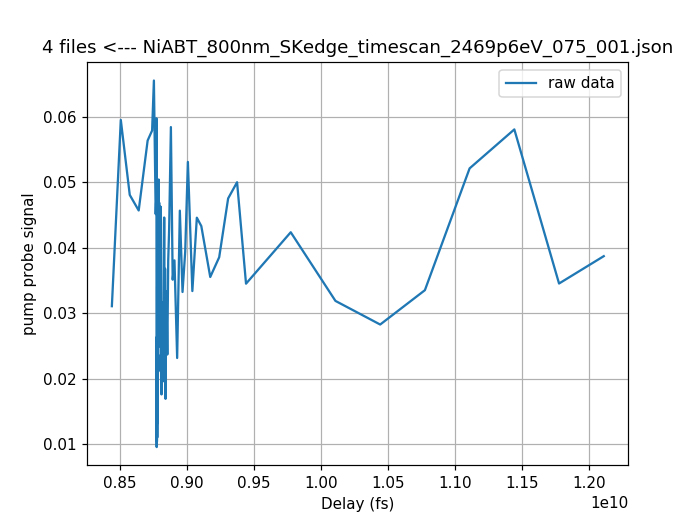

In [20]:
plt.figure()
plt.title('{} files <--- {}'.format(len(patch), patch[0].split('/')[-1]))
plt.plot(Delay_fs, Pump_probe_2fit, label = 'raw data')
#plt.plot(Delay_fs, errfunc_fwhm(Delay_fs, *parameters_fit), label = 'fit, {} fs'.format(np.round(width)))

#plt.ylim(-0.01,0.05)
#plt.xlim(-700, 700)
plt.ylabel('pump probe signal')
plt.xlabel('Delay (fs)')
plt.legend(loc = 'best')
plt.grid()
plt.show()

# Now with TT (PSEN) jitter correction

In [19]:
#px2fs = 2.2054                # new spectrometer (2 March 2021) 

#background_from_fit = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-03-07-17:59-psen-background.txt')
#peakback = np.loadtxt('/sf/alvra/data/p18938/scratch/2021-03-07-17:59-psen-peak-background.txt')


# Single scan

In [6]:
fc = FileChooser('/sf/alvra/data/p18956/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18956/raw/scan_info', filename='', show_hidden='False')

In [9]:
quantile_band = 0.75
Timezero = 222.6374

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero117, channel_delay_topas,
                   channel_PSEN_signal, channel_PSEN_bkg]#, channel_PSEN_image]
channel_list_all = channel_list_pp

roi_sig = [0, 2047, 400, 1150]
roi_back = [0, 2047, 400, 500]
px2fs = 2.2054                # new spectrometer (2 March 2021) 

#######################################################################################################
import itertools
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm  = scan.readbacks

DataFluo_pump = []
DataFluo_unpump = []
Pump_probe = []

Delay_fs_stage = []
Pump_probe_all = []
Delays_stage_all = []
arrTimes_all = []


for i, step in enumerate(scan):
    check_files_and_data(step)

    filename = scan.files[i][0].split('/')[-1].split('.')[0]

    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

    IzeroFEL_pump_shot = resultsPP[channel_Izero117].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero117].unpump
    DataFluo_pump_shot = - resultsPP[channel_PIPS_fluo].pump
    DataFluo_unpump_shot = - resultsPP[channel_PIPS_fluo].unpump
    
    sig = resultsPP[channel_PSEN_signal].pump
    back = resultsPP[channel_PSEN_bkg].pump
    #sig = crop_roi(resultsPP[channel_PSEN_image].pump, roi_sig).sum(axis = 1)
    #back = crop_roi(resultsPP[channel_PSEN_image].pump, roi_back).sum(axis = 1)
    delay_shot = resultsPP[channel_delay_topas].pump

    delay_shot_fs = (delay_shot - Timezero)*2/(3e8*1e3*1e-15)
    Delay_fs_stage.append(delay_shot_fs.mean())

    DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
    DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
    
    
    df_pump_probe = pd.DataFrame(Pump_probe_shot)
    Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
    # take bkg files closest in time    
    bkg_files = find_backgrounds(step.fnames[0],'/scratch')
    print ("File recorded at {}".format(datetime.fromtimestamp(bkg_files[2])))
    print (bkg_files[0])
    print (bkg_files[1])
    background_from_fit = np.loadtxt(bkg_files[0])
    peakback = np.loadtxt(bkg_files[1])
    
    arrTimes, arrTimesAmp, sigtraces, peaktraces = arrivalTimes('YAG', px2fs, back, sig, background_from_fit, peakback)    
    
    Delays_stage_all.append(delay_shot_fs)
    Pump_probe_all.append(Pump_probe_shot)
    arrTimes_all.append(arrTimes)
    
    clear_output(wait=True)
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    print ("correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))

Delays_stage_all = list(itertools.chain.from_iterable(Delays_stage_all))
arrTimes_all = list(itertools.chain.from_iterable(arrTimes_all))
Pump_probe_all = list(itertools.chain.from_iterable(Pump_probe_all))
    
Pump_probe = np.asarray(Pump_probe)
Pump_probe_all = np.asarray(Pump_probe_all)
arrTimes_all = np.asarray(arrTimes_all)
Delays_stage_all = np.asarray(Delays_stage_all)

Delays_corr = Delays_stage_all + arrTimes_all
#Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 49 of 49: Processing run_036967
correlation = 0.9797645897585239
Job done!
Quantiles for error bars: 0.125,0.875


In [23]:
binsize = 25 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_all),np.shape(Delays_corr))

#binList = np.arange(Delay_fs_stage[0], Delay_fs_stage[-1], binsize)
#xAxis = np.arange(Delay_fs_stage[0] + binsize/2, Delay_fs_stage[-1] - binsize/2, binsize)

binList = np.arange(Delays_corr[0], Delays_corr[-1], binsize)
xAxis = np.arange(Delays_corr[0] + binsize/2, Delays_corr[-1] - binsize/2, binsize)

s, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_all, statistic='mean', bins=binList)

(24198,) (24198,)


<IPython.core.display.Javascript object>


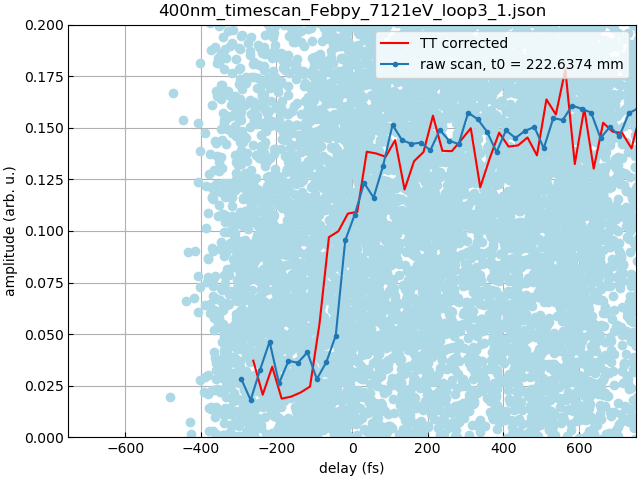

In [27]:
pp_uncorrected = Pump_probe[:,0]

fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.title(fc.selected_filename)
plt.tick_params(direction='in')
plt.plot(Delays_corr, Pump_probe_all, 'o', color='lightblue')
plt.plot(xAxis, s, color='red', label = 'TT corrected')
plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.plot(Delay_fs_stage, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(Timezero))
#plt.plot(xAxis, conv_exp_gauss_heaviside(xAxis,*parameters_TTcorr), label = 'fit')
#plt.plot(xAxis, conv_exp_gauss_heaviside2(xAxis,*parameters_TTcorr), label = 'fit')
#plt.plot(xAxis, errfunc_fwhm(xAxis,*parameters_TTcorr), label = 'fit')
plt.legend (loc = 'upper right')

#secax = ax.secondary_xaxis('top', functions = (fs2mm, mm2fs))
#secax.set_xlabel('delay (mm)')

#boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#boxtext = '\n'.join((r'Delta_t0 = {} fs'.format(np.round(t0_TTcorr, 5)),
#                     r't0_TT = {} mm'.format(np.round(Timezero + t0_TTcorr* (3e8*1e3*1e-15)/2,5)),
#            r'width = {} fs'.format(np.abs(np.round(width_TTcorr, decimals = 5)))))
#plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlim(-750, 750)
plt.ylim(0, 0.2)

plt.grid()
plt.show()

#print("Position t0_TT = {} mm".format(Timezero + t0_TTcorr* (3e8*1e3*1e-15)/2))

<IPython.core.display.Javascript object>


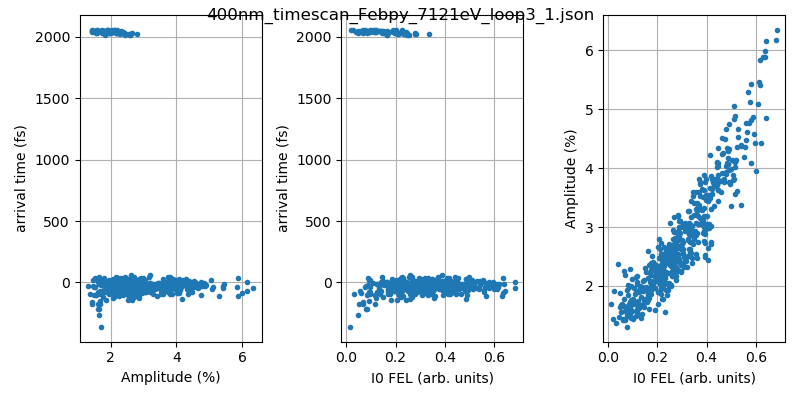

In [28]:
plt.figure(figsize=(8,4))
plt.suptitle(fc.selected.split('/')[-1])

plt.subplot(131)
plt.plot(arrTimesAmp, arrTimes, linestyle='None', marker = '.' )
plt.xlabel('Amplitude (%)')
plt.ylabel('arrival time (fs)')
plt.grid()

plt.subplot(132)
plt.plot(IzeroFEL_pump_shot, arrTimes, linestyle='None', marker = '.' )
plt.xlabel('I0 FEL (arb. units)')
plt.ylabel('arrival time (fs)')
plt.grid()

plt.subplot(133)
plt.plot(IzeroFEL_pump_shot, arrTimesAmp, linestyle='None', marker = '.' )
plt.xlabel('I0 FEL (arb. units)')
plt.ylabel('Amplitude (%)')
plt.grid()

plt.tight_layout()

plt.show()

In [44]:
arrTimesAmp_filtered = []
arrTimes_filtered = []
IzeroFEL_pump_shot_filtered = []

for i in range(1, len(arrTimes)):
    if(arrTimes[i] > 1500):
        arrTimesAmp_filtered.append(arrTimesAmp[i])
        arrTimes_filtered.append(arrTimes[i])
        IzeroFEL_pump_shot_filtered.append(IzeroFEL_pump_shot[i])

<IPython.core.display.Javascript object>


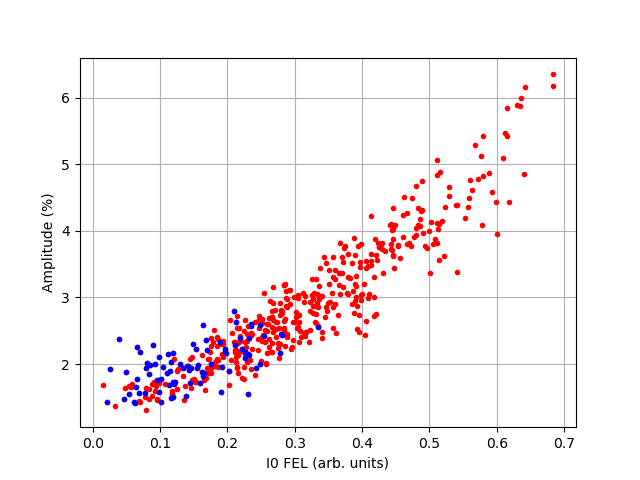

In [49]:
plt.figure()
plt.plot(IzeroFEL_pump_shot, arrTimesAmp, linestyle='None', marker = '.', color = 'red' )
plt.plot(IzeroFEL_pump_shot_filtered, arrTimesAmp_filtered, linestyle='None', marker='.', color = 'blue')
plt.xlabel('I0 FEL (arb. units)')
plt.ylabel('Amplitude (%)')
plt.grid()

(247,)
(497,)


<IPython.core.display.Javascript object>


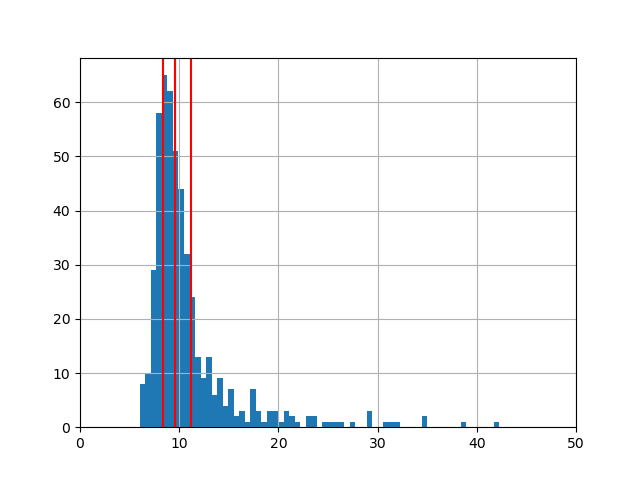

In [53]:
band = 0.5
levels = np.nanquantile(arrTimesAmp/IzeroFEL_pump_shot, [0.5, 0.5 - band/2, 0.5 + band/2])
cond = (arrTimesAmp/IzeroFEL_pump_shot > levels[1]) & (arrTimesAmp/IzeroFEL_pump_shot < levels[2])
print (arrTimes[cond].shape)
print (arrTimes.shape)

plt.figure()
plt.hist(arrTimesAmp/IzeroFEL_pump_shot, bins = 200)
plt.axvline(x=levels[0])
for xc in levels:
    plt.axvline(x=xc, color = 'red')
plt.xlim(0, 50)
plt.grid()
plt.show()

 # Timing tool traces & statistics

<IPython.core.display.Javascript object>


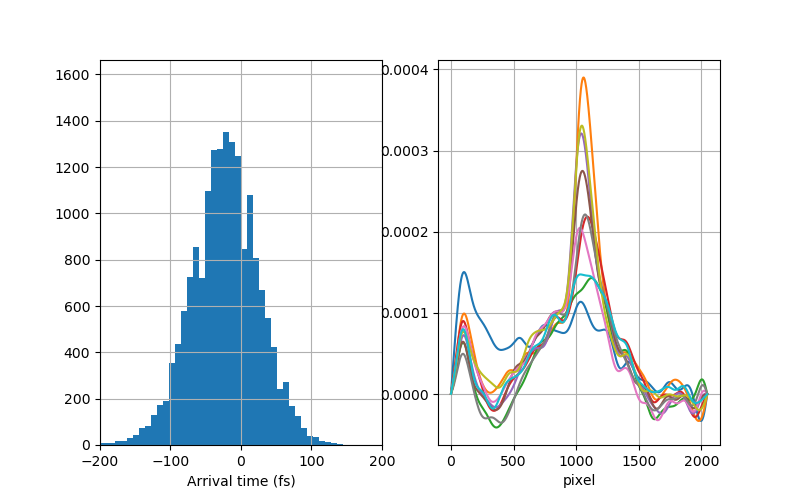

Statistics on all (24198,) shots of the scan
Offset compared to pixel 1048 is 551.7814556409621 fs
Jitter, i.e. width (std) of the histogram 926.7041299761713 fs
--------------------------------------------------------------
Statistics on (497,) shots of the last step of the scan
Offset compared to pixel 1048 is 317.3601661971831 fs
Jitter, i.e. width (std) of the histogram 783.7182211989572 fs


In [54]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.hist(arrTimes_all, bins=500)
plt.grid()
plt.xlim(-200,200)
plt.xlabel('Arrival time (fs)')

plt.subplot(122)
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(pixelNum, peaktraces[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()
plt.show()

print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_all)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_all)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_all)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes)))

# Loop of scans, WITH TT correction

In [7]:
datafiles = []
for file in glob('/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:-1]
patch

['/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_1.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_2.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_3.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_4.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_5.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_6.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_7.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_8.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_9.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_10.json',
 '/sf/alvra/data/p18938/raw/scan_info/400nm_timescan_Febpy_7121eV_loop3_11.json']

In [12]:
step.fnames[0]

'/sf/alvra/data/p18938/raw/400nm_timescan_Febpy_7121eV_loop3_1/run_036967.BSDATA.h5'

In [13]:
quantile_corr = 0.5
Timezero_loop = 222.6234
binsize = 25

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero117, channel_delay_harm,
                   channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp

px2fs = 2.2054                # new spectrometer (2 March 2021) 

########################################################################
import itertools
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

scan_number = []
width_fs_loop_TT = []
t0_fs_loop_TT =[]
ArrTimeRuns = []
ArrTimeScans = []

s_all = []
transients = []
delays_axis = []
pars = []

for json_file in patch:
    print (json_file)
    scan_number.append(json_file.split('/')[-1].split('_')[-1].split('.')[0])
    
    scan = SFScanInfo(json_file)
    Delay_mm = scan.readbacks

    Delay_fs_stage = []
    Pump_probe = []
    Pump_probe_all_loop = []
    Delays_stage_all_loop = []
    arrTimes_all_loop = [] 
    
    for i, step in enumerate(scan):
        
        edgePosRun = []        

     #   try:
            
        resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

        IzeroFEL_pump_shot = resultsPP[channel_Izero117].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero117].unpump
        DataFluo_pump_shot = - resultsPP[channel_PIPS_fluo].pump
        DataFluo_unpump_shot = - resultsPP[channel_PIPS_fluo].unpump

        sig = resultsPP[channel_PSEN_signal].pump
        back = resultsPP[channel_PSEN_bkg].pump
        delay_shot = resultsPP[channel_delay_harm].pump

        delay_shot_fs = (delay_shot - Timezero_loop)*2/(3e8*1e3*1e-15)
        Delay_fs_stage.append(delay_shot_fs.mean())

        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm

        Pump_probe_all_loop.append(Pump_probe_shot)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))

        # take bkg files closest in time    
        bkg_files = find_backgrounds(step.fnames[0],'/scratch')
        print ("File recorded at {}".format(datetime.fromtimestamp(bkg_files[2])))
        print (bkg_files[0])
        print (bkg_files[1])
        background_from_fit = np.loadtxt(bkg_files[0])
        peakback = np.loadtxt(bkg_files[1])

        arrTimes, arrTimesAmp, sigtraces, peaktraces = arrivalTimes('YAG', px2fs, back, sig, background_from_fit, peakback)    
        
        Delays_stage_all_loop.append(delay_shot_fs)
        arrTimes_all_loop.append(arrTimes)
        
        ArrTimeRuns.append(np.array(np.nanmean(arrTimes)))

        clear_output(wait=True)
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), step.fnames[0]))
        print ('----------------')
        print ("correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))
        print ('----------------')
    #    except:
   #         print ('skipped run')
        
    ArrTimeScans.append(np.array(np.nanmean(ArrTimeRuns)))
    
    Delays_stage_all_loop = list(itertools.chain.from_iterable(Delays_stage_all_loop))
    arrTimes_all_loop = list(itertools.chain.from_iterable(arrTimes_all_loop))
    Pump_probe_all_loop = list(itertools.chain.from_iterable(Pump_probe_all_loop))
    
    Pump_probe_all_loop = np.asarray(Pump_probe_all_loop)
    arrTimes_all_loop = np.asarray(arrTimes_all_loop)
    Delays_stage_all_loop = np.asarray(Delays_stage_all_loop)
    
    Delays_corr_loop = Delays_stage_all_loop + arrTimes_all_loop
    
    print (np.shape(Pump_probe_all_loop),np.shape(Delays_corr_loop))
    
    binList_loop = np.arange(-400, 800, binsize)
    xAxis_loop = np.arange(-400 + binsize/2, 800 - binsize/2, binsize)
    
    s_loop, binEdges, binNumber = binned_statistic(Delays_corr_loop, Pump_probe_all_loop, statistic='mean', bins=binList_loop)
    s_all.append(s_loop)
    
    index = ~(np.isnan(xAxis_loop) | np.isnan(s_loop))
    parameters_TTcorr_loop,extras = curve_fit(errfunc_fwhm, xAxis_loop[index], s_loop[index], p0 = [0, 0.02, 100, 0])
    #errfunction: x0, amplitude, fwhm, offset
    t0_fs_loop_TT.append(parameters_TTcorr_loop[0])
    width_fs_loop_TT.append(np.abs(parameters_TTcorr_loop[2]))
    
    transients.append(s_loop)
    delays_axis.append(xAxis_loop)
    pars.append(parameters_TTcorr_loop)
    
print ('Job done!')


Step 49 of 49: Processing /sf/alvra/data/p18938/raw/400nm_timescan_Febpy_7121eV_loop3_11/run_037457.BSDATA.h5
----------------
correlation = 0.9793645569580282
----------------
(24153,) (24153,)
Job done!


<IPython.core.display.Javascript object>


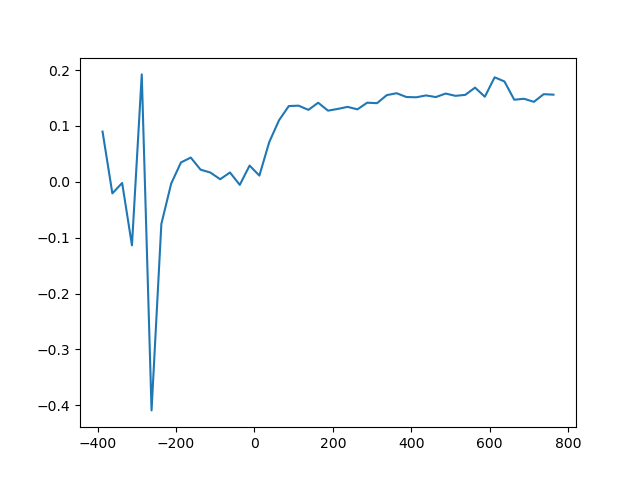

In [14]:
plt.figure()
plt.plot(xAxis_loop, s_loop)
plt.show()

<IPython.core.display.Javascript object>


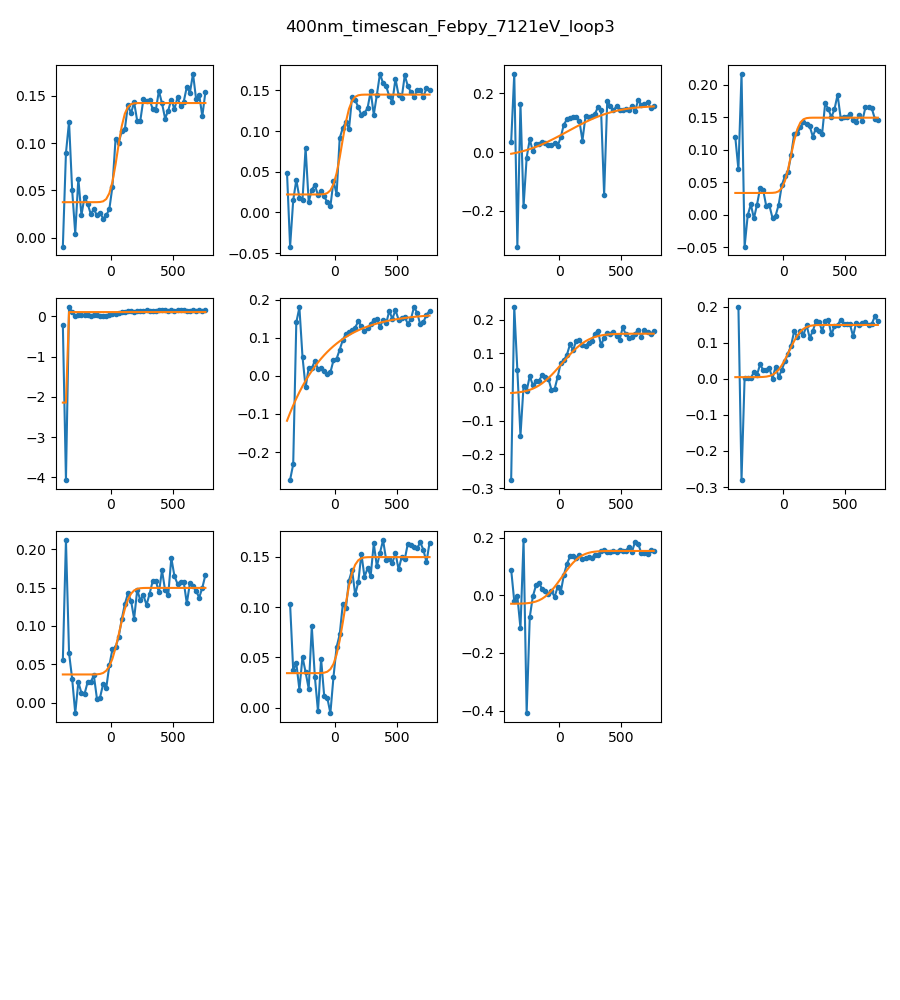

In [19]:
np.array(transients).shape

fig = plt.figure(figsize=(9,10))
fig.suptitle(patch[0][36:-7])
t0_fs_loop_TT = []
for num, transient in enumerate(transients):
    ax1 = fig.add_subplot(4,4,num+1)
    ax1.plot(delays_axis[num], transient, marker='.')
    index = ~(np.isnan(delays_axis[num]) | np.isnan(transient))
    pars,extras = curve_fit(errfunc_fwhm, delays_axis[num][index], transient[index], p0 = [0, 0.02, 100, 0])
#     print(pars[2])
    t0_fs_loop_TT.append(pars[2])
    ax1.plot(delays_axis[num], errfunc_fwhm(delays_axis[num], *pars))
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


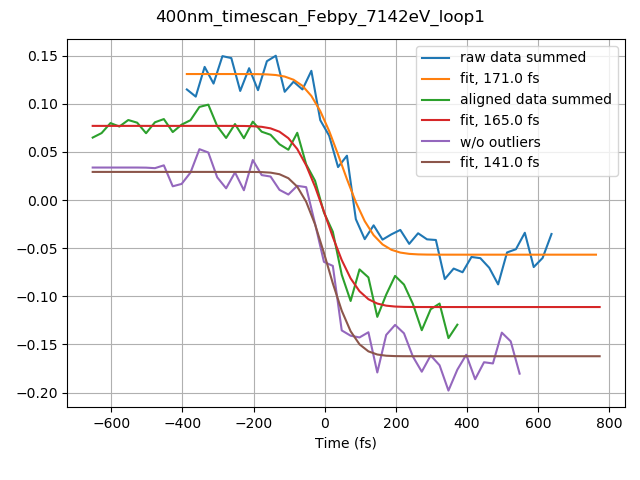

In [207]:
xAxis_corr = np.array(delays_axis) - np.array([t0_fs_loop_TT]).T
tmin, tmax = (min(xAxis_corr.ravel()), max(xAxis_corr.ravel()))
xAxis_common = np.arange(tmin, tmax, binsize)
xAxis_common
curves = []
for num, transient in enumerate(transients):
    curves.append(np.interp(xAxis_common, xAxis_corr[num], transient))
curves = np.array(curves)

transient_aver = np.average(curves, axis=0)

fig = plt.figure()
fig.suptitle(patch[0][36:-7])
ax1 = fig.add_subplot(1,1,1)
ax1.plot(xAxis, s_tofit, label = 'raw data summed')
plt.plot(xAxis, errfunc_fwhm(xAxis, *parameters_fit), label = 'fit, {} fs'.format(np.round(width)))

ax1.plot(xAxis_common, -0.05+transient_aver/0.4, label = 'aligned data summed')
index = ~(np.isnan(xAxis_common) | np.isnan(transient_aver))
pars,extras = curve_fit(errfunc_fwhm, xAxis_common[index], transient_aver[index], p0 = [-0.04, 0.1, 0, 100])
ax1.plot(xAxis_common, -0.05+errfunc_fwhm(xAxis_common, *pars)/0.4, label='fit, {} fs'.format(np.round(pars[3])))

curves_healthy = []
for num in [0,1,2,3,4,5,6,10,11,12]:
    curves_healthy.append(np.interp(xAxis_common, xAxis_corr[num], transients[num]))
curves_healthy = np.array(curves_healthy)

transient_healthy = np.average(curves_healthy, axis=0)
ax1.plot(xAxis_common, -0.1+transient_healthy/0.4, label = 'w/o outliers')
pars,extras = curve_fit(errfunc_fwhm, xAxis_common[index], transient_healthy[index], p0 = [-0.04, 0.1, 0, 100])
ax1.plot(xAxis_common, -0.1+errfunc_fwhm(xAxis_common, *pars)/0.4, label='fit, {} fs'.format(np.round(pars[3])))

ax1.set_xlabel('Time (fs)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.grid()
ax1.legend()
plt.show()



In [181]:
curves


array([[ 0.02230833,  0.02230833,  0.02230833,  0.02230833,  0.02230833,
         0.02230833,  0.02230833,  0.02230833,  0.02230833,  0.02230833,
         0.04083355,  0.06362342,  0.08207613,  0.06027206,  0.02995463,
         0.04213056,  0.05096038,  0.04383963,  0.06108285,  0.048884  ,
         0.03561799,  0.03008302,  0.01865335,  0.05088642,  0.0333116 ,
         0.00741675,  0.01220877,  0.0226554 , -0.00444036, -0.03320387,
        -0.03389252, -0.01764571, -0.03259966, -0.01654635, -0.02158358,
        -0.04123519, -0.02670241, -0.01719411, -0.03626631, -0.03116138,
        -0.03654261, -0.05902652, -0.05548953, -0.05901035, -0.04636695,
        -0.01305993, -0.01277185, -0.02155529, -0.0307189 , -0.03714427,
        -0.03355105,  0.00205757,         nan,         nan,         nan,
                nan,         nan,         nan],
       [ 0.05608341,  0.05608341,  0.05608341,  0.05608341,  0.05608341,
         0.05608341,  0.05608341,  0.05608341,  0.05040849,  0.03334934,
   

In [108]:
index = ~(np.isnan(xAxis) | np.isnan(s_tofit))

parameters_fit,extras = curve_fit(errfunc_fwhm, xAxis[index], s_tofit[index] , p0 = [0, 700, 0.02, 100])
width = parameters_fit[3]
print ('width = {} fs'.format(width))

width = 171.24337288996134 fs


In [148]:
t0_fs_loop_TT

[0.008785501990314432,
 0.012836793040493169,
 0.007197069067528366,
 0.016641121755046506,
 0.019048913592861427,
 0.013747659365648777,
 0.01794795692392158,
 0.02127466767406208,
 -0.001383816207937875,
 0.01884945511052784,
 0.0158784972269276,
 0.019128845262932227,
 0.018758394927630664]

In [126]:
np.shape(s_all)
s_all = np.asarray(s_all)
s_tofit = s_all.mean(axis = 0)/0.4

<IPython.core.display.Javascript object>


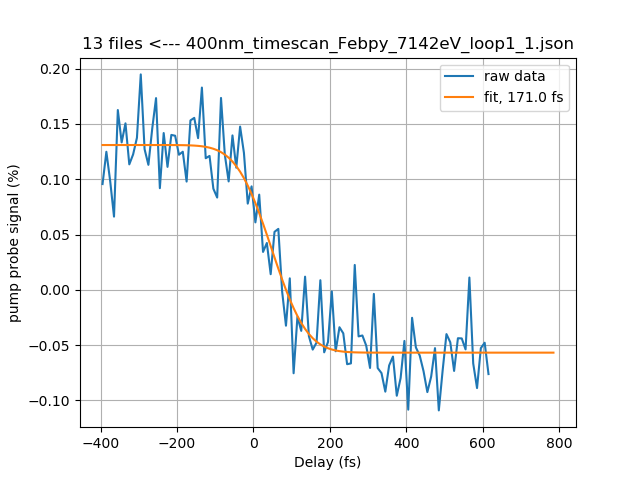

In [109]:
plt.figure()
plt.title('{} files <--- {}'.format(len(patch), patch[0].split('/')[-1]))
plt.plot(xAxis, s_tofit, label = 'raw data')
plt.plot(xAxis, errfunc_fwhm(xAxis, *parameters_fit), label = 'fit, {} fs'.format(np.round(width)))


#plt.ylim(-0.01,0.05)
#plt.xlim(-700, 700)
plt.ylabel('pump probe signal (%)')
plt.xlabel('Delay (fs)')
plt.legend(loc = 'best')
plt.grid()
plt.show()

## Load one step and check I0 filtering

In [13]:
filenumber = 31

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_delay_topas]

min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

step = scan[filenumber]
print (step)
resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
step.close()

IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Delay = {} mm".format(Delay_mm[filenumber]))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))


Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18442/res/JF_pedestals/pedestal_20200131_2048.JF02T09V02.res.h5
jungfrau file: 21:59 31.01.2020
pedestal file: 20:58 31.01.2020
    mtime difference: 1:00:38.177874
SFDataFiles("/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_2/run_001427.BSREAD.h5", "/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_2/run_001427.JF02T09V02.h5"): 49 channels

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET   1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY  1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50

<IPython.core.display.Javascript object>


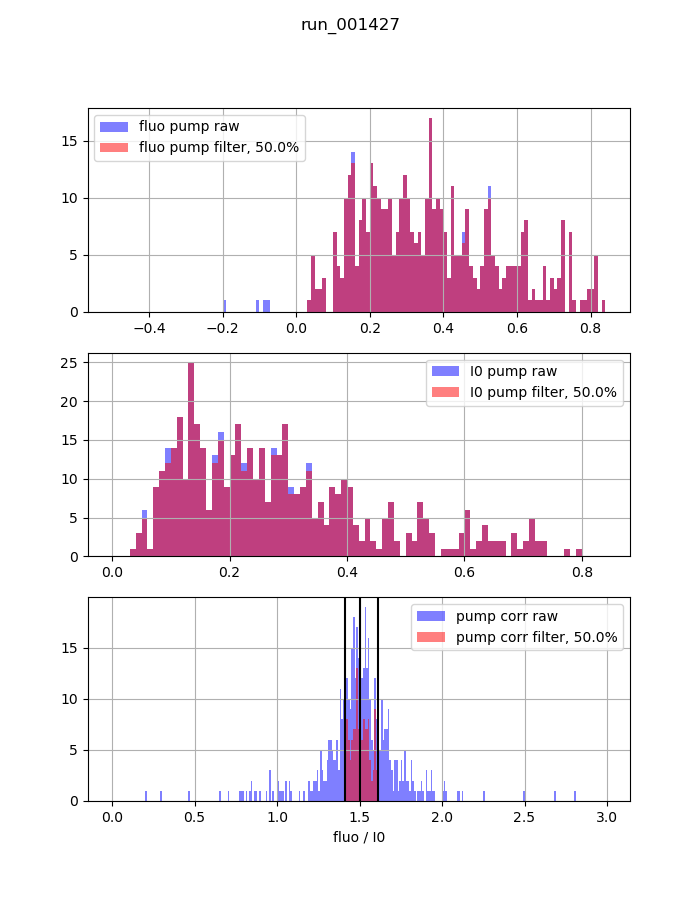

In [23]:
plt.figure(figsize = (7,9))
plt.suptitle(scan.files[filenumber][0].split('/')[-1].split('.')[0])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.85,0.01), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(0,3,0.01)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

plt.show()

#  Check data distributions with quantiles 

In [24]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

Timezero = 175.70976 # position of Timezero on PP delay (in mm!)

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_delay_harm]

####################################################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Delay_mm = scan.readbacks

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
        
    IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
    IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
    DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
    DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
    
    DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
    DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
    Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
    
    df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
    df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
    df_pump_probe = pd.DataFrame(Pump_probe_shot)
          
    DataFluo_pump.append(np.nanquantile(df_pump, quantiles))
    DataFluo_unpump.append(np.nanquantile(df_unpump, quantiles))
    Pump_probe.append(np.nanquantile(df_pump_probe, quantiles))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")

Step 51 of 51: Processing run_001446

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET   1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY  1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS 1999 / 1999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1999 / 1999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 500 pump and 500 unpump shots
Job done!


<IPython.core.display.Javascript object>


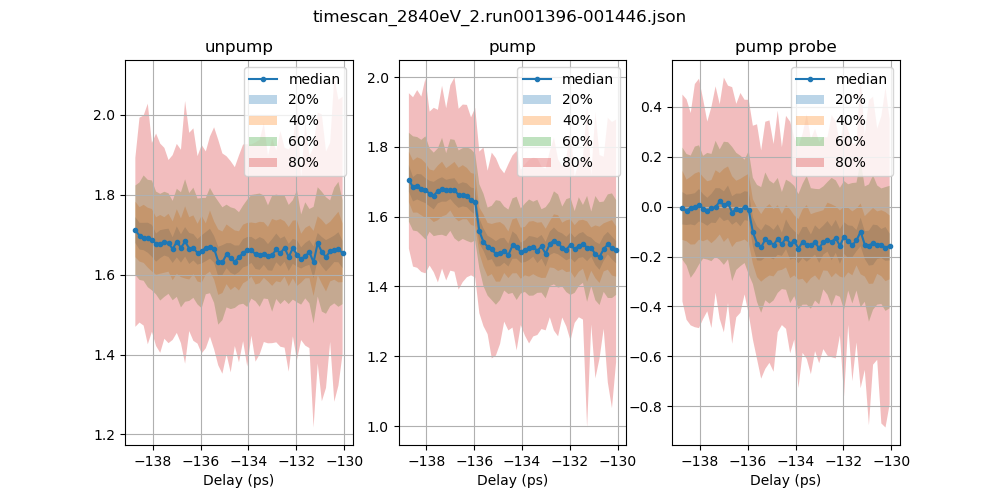

In [25]:
plt.figure(figsize = (10,5))
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

plt.subplot(1,3,1)
plt.plot(Delay_ps, DataFluo_unpump[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,4]),np.array(DataFluo_unpump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,3]),np.array(DataFluo_unpump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,2]),np.array(DataFluo_unpump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_unpump[:,1]),np.array(DataFluo_unpump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('unpump')
plt.legend(loc="best")
#plt.ylabel("XAS ground state")
plt.xlabel("Delay (ps)")

plt.subplot(1,3,2)
plt.plot(Delay_ps, DataFluo_pump[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,4]),np.array(DataFluo_pump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,3]),np.array(DataFluo_pump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,2]),np.array(DataFluo_pump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(DataFluo_pump[:,1]),np.array(DataFluo_pump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump')
plt.legend(loc="best")
#plt.ylabel("XAS ground state")
plt.xlabel("Delay (ps)")

plt.subplot(1,3,3)
plt.plot(Delay_ps, Pump_probe[:,0],label='median',marker='.' )
plt.fill_between(Delay_ps,np.array(Pump_probe[:,4]),np.array(Pump_probe[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,3]),np.array(Pump_probe[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,2]),np.array(Pump_probe[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Delay_ps,np.array(Pump_probe[:,1]),np.array(Pump_probe[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump probe')
plt.legend(loc="best")
#plt.ylabel("Delta XAS")
plt.xlabel("Delay (ps)")

plt.show()

In [ ]:
import photodiag

#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
DIRcalib = '/sf/alvra/data/p18442/res/PhotoDiag/scan_info/'

CalibrationFn = DIRcalib + '2020-01-31_17:42:38.palm_etof'

energyFrom =  1200
energyTo =    1500
energySteps = 2000
palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))

palm.load_etof_calib(CalibrationFn)

In [ ]:
quantile_corr = 0.5
ev2fsCalib= -18.913301646032846    # This is from THz scan_010
Timezero = 155.35                 # position of Timezero on PP delay (in mm!)
                
########################################################################


###########################################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
#json_file = DIR_json + scan_name + "_scan_info.json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 3
print ("Processing",numFiles,"files")
print (json_file)

DataFluo_pump = []
DataFluo_unpump = []
Pump_probe = []
Pump_probe_all =[]
Delays_stage_mm = []
Delays_PALM_all = []
Number_Nans = 0
Number_shots = 0

for i in range(0, numFiles):
    filename = str(data['scan_files'][i][0])
    testdata = check_files_and_data(filename)

    if (testdata):# and (i!=12):
        #clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        # Load pump probe data:
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_stage_mm, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events2(filename, channel_delay)
        
        # Load PALM data:
        pulse_id_PALM, delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(filename, debug=True)
       
        # Load pump-unpump scheme:
        (reprate_light, reprate_dark), ratioLaser, ratioFEL = load_reprates_laser_pump(filename)
        
        pulse_id_PALM = pulse_id_PALM[:len(reprate_light)]
        delays_PALM_eV = delays_PALM_eV[:len(reprate_light)]
        cross_corr = cross_corr[:len(reprate_light)]
        input_data_0 = input_data['0'][:][:len(reprate_light)]
        input_data_1 = input_data['1'][:][:len(reprate_light)]
        
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        fullArraySize = int(len(delays_PALM_fs)/(ratioLaser * ratioFEL)*(sum(reprate_light)/sum(reprate_dark)))
        
        beamOK = ((np.amax(input_data_0,axis=1) > 0.03) & (np.amax(input_data_1,axis=1) > 0.03))
        #beamOK = (np.amax(input_data_0,axis=1) > 0.0)# & (delays !=0.0)
        
        delays_beamOK_light = delays_PALM_fs[beamOK & reprate_light]
        cross_corr_OK = cross_corr[beamOK & reprate_light]
        pulseID_OK = pulse_id_PALM[beamOK & reprate_light]
        refData_OK = input_data_0[beamOK & reprate_light]
        StrData_OK = input_data_1[beamOK & reprate_light]
        
        NumberOK = len(delays_beamOK_light) 
        shots2pad = fullArraySize - NumberOK
        
        try:        
            delays_beamOK_light = np.pad(delays_beamOK_light, (0, shots2pad), constant_values=np.NaN)
            Pump_probe_shot = np.pad(Pump_probe_shot, (0, len(delays_beamOK_light)-len(Pump_probe_shot)), constant_values=np.NaN)
            print ('Ratio pump/unpump is {}:1 at pump rep rate {} Hz, light shots are {}, need to pad {} shots' \
                   .format(ratioLaser-1, 100/ratioFEL, NumberOK, shots2pad))
            Number_Nans = Number_Nans + shots2pad
            Number_shots = Number_shots + NumberOK
        except:
            print ('Ratio pump/unpump is {}:1 at pump rep rate {} Hz, they are not commensurate, cannot pad. Keep {} light shots' \
                   .format(ratioLaser-1, 100/ratioFEL, NumberOK))
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
        Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        Delays_PALM_all.append(delays_beamOK_light)
        
        Pump_probe_all.append(Pump_probe_shot)

DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
Pump_probe_all = np.asarray(Pump_probe_all)
Delays_stage_mm = np.asarray(Delays_stage_mm)
Delays_PALM_all = np.asarray(Delays_PALM_all)  

Delays_stage_mm = np.asarray(Delays_stage_mm)# * 3e8 *1e3 /2        
Delays_stage_fs = (Delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

print ("Job done! Total shots are {}, Nans are {}".format(Number_shots, Number_Nans))

In [ ]:
print (Delays_PALM_all.shape, Pump_probe_all.shape, Delays_stage_fs.shape)

In [ ]:
def CorrectJitterSignal(DelaysPALM_fs, DelaysSTAGE_fs, Signal, reBinFac, quantile_rebin):
    print (DelaysPALM_fs.shape, DelaysSTAGE_fs.shape, Signal.shape)
    #Delaystmp = DelaysRAW#*calibPALM
    CorrectedTime = DelaysSTAGE_fs + ((DelaysPALM_fs)-(np.nanmean(DelaysPALM_fs)))
    PALMSteps =  DelaysSTAGE_fs.shape[0]*reBinFac
    CorrectedTime = CorrectedTime.ravel()
    
    #binsCentre = np.linspace(DelaysSTAGE_fs[0], DelaysSTAGE_fs[-1], PALMSteps)
    #digi = np.digitize(CorrectedTime, binsCentre[:,0])
    
    binsCentre = np.linspace(np.nanmin(CorrectedTime), np.nanmax(CorrectedTime), PALMSteps)
    digi = np.digitize(CorrectedTime, binsCentre)

    signalProc = []
    signalErr = []
    signalProc_Q = []
    signalProcSS = []
    Num_points = []
    
    for i in range(PALMSteps):
        ind = digi==i
        num_points = np.count_nonzero(ind)
        signalProc.append(np.nanmedian(Signal[ind]))
        signalProcSS.append(Signal[ind])
        Num_points.append(num_points)
        if (num_points == 0):
            #print ('put NaNs')
            df_signal = pd.DataFrame(Signal[ind])
            signalProc_Q.append([np.NaN, np.NaN, np.NaN])
        else:
            #print ('Ok')
            df_signal = pd.DataFrame(Signal[ind])
            signalProc_Q.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_rebin/2, 0.5 + quantile_rebin/2]))
        
    signalProc= np.array(signalProc)
    signalErr = np.array(signalErr)
    signalProc_Q= np.array(signalProc_Q)
    signalProcSS= np.array(signalProcSS)
    Num_points = np.asarray(Num_points)
    print (Num_points.sum())
    print ('Total shots = {}, Delta time = {} fs'.format(Num_points.sum(),(binsCentre[-1]-binsCentre[0])/PALMSteps))

    return binsCentre, CorrectedTime, signalProc, signalProc_Q, signalProcSS, Num_points

In [ ]:
quantile_reBin = 0.2
reBin_factor = 4

############################################################################

BinsCentre, CorrectedTime, Signal, Signal_Q, SignalSS, ShotsPerBin = \
CorrectJitterSignal(Delays_PALM_all, Delays_stage_fs, Pump_probe_all.ravel(), reBin_factor, quantile_reBin)

In [ ]:
plt.figure(figsize = (8,5))
#plt.title (scan_name + scan_range)
plt.title (scan_name)
plt.plot(Delays_stage_fs.ravel(), pump_probe, label='original, {}%'.format(quantile_corr*100),marker='.', color = 'coral')

#plt.plot (BinsCentre,Signal)
#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SignalSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (BinsCentre, Signal_Q[:,0], label='Re-binned factor {}, {}% '.format(reBin_factor, quantile_reBin*100 ), marker='.', color = 'forestgreen')
plt.fill_between(BinsCentre.ravel(), Signal_Q[:,1], Signal_Q[:,2], color='forestgreen', alpha =0.2)
plt.legend(loc="best")
plt.xlabel("delay (fs)")
#plt.xlim(-2000, 1000)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.show()

#plt.savefig (savedir + scan_name + '_rebin.png')

In [ ]:
plt.figure(figsize = (8,10))
plt.suptitle (scan_name)

plt.subplot(211)
plt.title('Delta_t (rebin) = {} fs'.format((BinsCentre[-1]-BinsCentre[0])/len(BinsCentre)))
plt.plot(Delays_stage_fs.ravel(), pump_probe, label='original, {}%'.format(quantile_corr*100),marker='.', color = 'orange')
plt.plot (BinsCentre, Signal_Q[:,0], label='Re-binned factor {}, {}% '.format(reBin_factor, quantile_reBin*100 ), marker='.', color = 'forestgreen')
plt.fill_between(BinsCentre.ravel(), Signal_Q[:,1], Signal_Q[:,2], color='forestgreen', alpha =0.2)
plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.xlim(-3000, 5000)
plt.ylim(-0.4, 0.2)
plt.grid()

plt.subplot(212)
plt.plot(BinsCentre, ShotsPerBin,marker='.', color = 'red')
plt.xlabel("delay (fs), rebinned")
plt.ylabel("Shots per bin")
plt.xlim(-3000, 5000)
plt.grid()

plt.show()
plt.savefig (savedir + scan_name + '_rebin.png')

# Fit delay scan -- original

In [ ]:
Timezero = 155.26126
Pump_probe_tofit = pump_probe.copy()
Delay_mm_tofit = Delay_mm.copy()
Delay_ps_tofit = (Delay_mm_tofit - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_mm_tofit) | np.isnan(Pump_probe_tofit))

parameters_mm,extras = curve_fit(errfunc_fwhm, Delay_mm_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, Timezero, 0.5])
t0_mm = parameters_mm[2]
width_mm = parameters_mm[3]

print("Position t0 =",np.round(t0_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,3))*1000,"um")

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(Delay_ps_tofit) | np.isnan(Pump_probe_tofit))

parameters_ps,extras = curve_fit(errfunc_fwhm, Delay_ps_tofit[index], Pump_probe_tofit[index], p0 = [0, 0.2, 0, 0.5])
t0_ps = parameters_ps[2]
width_ps = parameters_ps[3]

print("Position t0 =",np.round(t0_ps,5),"ps")
print("Width =",np.abs(np.round(width_ps,3))*1000,"fs")

In [ ]:
#... and the plot with the fit curve

plt.figure(figsize = (10,5))
plt.subplot(121)

plt.plot(Delay_mm, pump_probe, label='pump probe, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_mm, err_low_pump_probe, err_high_pump_probe, color='lightblue')
plt.plot(Delay_mm_tofit, errfunc_fwhm(Delay_mm_tofit,*parameters_mm))
plt.grid()
plt.xlabel("delay (mm)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay (mm)')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(t0_mm, 5)) + ' mm' )


plt.subplot(122)

plt.plot(Delay_ps_tofit, pump_probe, label='pump probe, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Delay_ps_tofit, err_low_pump_probe, err_high_pump_probe, color='lightblue')
plt.plot(Delay_ps_tofit, errfunc_fwhm(Delay_ps_tofit,*parameters_ps))
plt.grid()
plt.xlabel("delay (ps)")
plt.legend(loc="best")
plt.gca().set_title('width = {} fs'.format(np.abs(round(width_ps,3))*1000))
plt.legend(loc="best")
#plt.title('width=' + str(np.round(width_ps_ps, 5)) + ' fs' )

print ('t0 = {} mm'.format(np.round(t0_mm, 5)))
plt.show()

# Fit delay scan -- corrected data

In [ ]:
# Now fit with error funciton (defined above)
index = ~(np.isnan(BinsCentre.ravel()) | np.isnan(Signal))

parameters_rebin_ps,extras_rebin = curve_fit(errfunc_fwhm, BinsCentre.ravel()[index], Signal[index], p0 = [0, 25, 0, 500])
t0_ps_rebin = parameters_rebin_ps[2]
width_ps_rebin = parameters_rebin_ps[3]

print("Position t0 =",np.round(t0_ps_rebin,5),"ps")
print("Width =",np.abs(np.round(width_ps_rebin,3)),"fs")

In [ ]:
plt.figure(figsize = (8,10))
plt.suptitle (scan_name + ' ----> width = {} fs'.format(np.abs(np.round(width_ps_rebin,3))))

plt.subplot(211)
plt.plot(Delays_stage_fs.ravel(), pump_probe, label='original, {}%'.format(quantile_corr*100),marker='.', color = 'blue')
plt.plot (BinsCentre, Signal, label='Re-binned factor {} '.format(reBin_factor), marker='.', color = 'forestgreen')
#plt.fill_between(BinsCentre.ravel(), Signal_Q[:,1], Signal_Q[:,2], color='forestgreen', alpha =0.2)
plt.plot (BinsCentre, errfunc_fwhm(BinsCentre,*parameters_rebin_ps), color ='coral')
plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()

plt.subplot(212)
plt.plot(BinsCentre, ShotsPerBin,marker='.', color = 'red')
plt.xlabel("delay (fs), rebinned")
plt.ylabel("Shots per bin")
plt.grid()

plt.show()

plt.savefig (savedir + scan_name + '_rebin.png')

In [ ]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.2

Timezero = 155.35 # position of Timezero on PP delay (in mm!)

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_delay)
        
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
        
        threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
        threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
        threshold_fluo_pump = DataFluo_pump_shot > min_fluo
        threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo
        
        thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                            threshold_fluo_pump & threshold_fluo_unpump

        DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
        DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]
        
        print ("survived {}/{} shots".format(len(DataFluo_pump_shot), len(DataFluo_unpump_shot)))
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        
        med = np.median(DataFluo_unpump_shot_norm)
        qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)
        
        condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
        condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high
        
        med = np.median(DataFluo_pump_shot_norm)
        qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
        qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

        condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
        condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high
        
        correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                             condition_corr_pump_low & condition_corr_pump_high

        DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        print ("survived {}/{} shots".format(len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm)))
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0, 1]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0, 1]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0, 1]))
        
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
                  
Delay_mm = np.asarray(Delay_mm)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

print ("Job done!")


In [ ]:
timelist=np.concatenate((np.arange(-1.5,-0.5-1,-1))-, np.arange(2847,2845.5-.5,-0.5),np.arange(2845,2835.25-.25,-0.25),np.arange(2835,2834.5-.5,-0.5),np.arange(2834,2831-1,-1)))

In [ ]:
def exponential_func(x,a,b,c):
    return a*np.exp(-b*x)+c

def bi_exponential_func(x,a,b,c, d, e):
    return a*np.exp(-b*x)+c+d*np.exp(-e*x)

Delay_ps = np.array(Delay_ps)
t_range = Delay_ps > 0.02 

popt,pcov = curve_fit(exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 10, 0.2))
popt2,pcov2 = curve_fit(bi_exponential_func, Delay_ps[t_range], -Pump_probe[t_range], p0 = (0.4, 0.6, 0.2, 0.4, 6))

xx= np.linspace(0, 20, 100)
yy = exponential_func(xx, *popt)
yyy= bi_exponential_func(xx, *popt2)

plt.figure()
plt.plot(Delay_ps, -Pump_probe)
plt.plot(xx, yy)
plt.plot(xx, yyy)


print(popt)
print(popt2)
